In [94]:
import os
from glob import glob
import pandas as pd
import numpy as np
from PIL import Image
import os.path as op

In [97]:
# You first need to set you directory structure
# and collect the behavioral files for the localizer and the
# study task separately.  Given that each task will be modeled
# separately treat them separately.
sid = ["001"]
proj_dir = "/Users/chloehampson/Desktop/classes/psb6351/"
behav_dir = op.join(proj_dir, f"raw/sub-{sid[0]}/ses-01/behav")
deriv_dir = op.join(proj_dir, "derivatives")
evs_dir = op.join(deriv_dir, f"first_lvl/sub-{sid[0]}/evs")
os.makedirs(evs_dir, exist_ok=True)


# Get a list of my study task json and nifti converted files
behav_tsv = sorted(glob(behav_dir + "/*.tsv"))
behav_loc_tsv = behav_tsv[0:2]
behav_task_tsv = behav_tsv[2:7]
# use os.path.join or Pathlib to define location of files
# use glob and sort to grab relevant files...I would separately handle localizer and task .tsv files

In [80]:
behav_task_tsv

['/Users/chloehampson/Desktop/classes/psb6351/raw/sub-001/ses-01/behav/sub-001_task-study_run-1_events.tsv',
 '/Users/chloehampson/Desktop/classes/psb6351/raw/sub-001/ses-01/behav/sub-001_task-study_run-2_events.tsv',
 '/Users/chloehampson/Desktop/classes/psb6351/raw/sub-001/ses-01/behav/sub-001_task-study_run-3_events.tsv',
 '/Users/chloehampson/Desktop/classes/psb6351/raw/sub-001/ses-01/behav/sub-001_task-study_run-4_events.tsv']

In [98]:
# In this cell I'm going to first work on the localizer task

# Define variables that can distinguish between runs and have
# onset times and their duration embedded.  I used dictionaries
# This will need to be accomplished for each type of stimulus or
# or regressor you want to isolate onset times for

# Iterate over your text files for the localizer task.
# The variable curr_behav_file will be a string variable with
# the full path to the separate runs of the localizer task. idx is a counter
# used for indexing.

# Define lists to hold all onsets and durations for both runs
face_runs_data = []
scene_runs_data = []

# Iterate over your text files for the localizer task
for idx, curr_behav_file in enumerate(behav_loc_tsv):
    # This is where I defined the keys in my dictionaries that were created above
    # and defined the output associated with each key as an empty list
    # example --> name_of_dictionary_defined_above[f'run{SOMETHING}'] = []

    # I'm using the pandas function read_csv to read in the log files
    curr_behav_data = pd.read_csv(curr_behav_file, sep="\t")

    # Given that the localizer task is a block design you don't need
    # the onset time of each stimulus.  You just need the first and then
    # the total duration of all stimuli to create your blocked time
    # to convolve with your hemodynamic response.  I used temporary lists
    # to grab all onset times and then picked the first...you can choose
    # another way.

    # iterating over ????? here...i is counter for indexing
    # What column header would you want to iterate over?  Why?

    # Temporary lists to store onsets
    tmp_face_onset = []
    tmp_scene_onset = []
    tmp_math_onset = []
    tmp_face_math = []
    tmp_scene_math = []

    for i, curr_trial_type in enumerate(curr_behav_data["trial_type"]):
        if curr_trial_type == "face" and i % 20 == 0:
            tmp_face_onset.append(curr_behav_data["onset"][i])
        elif curr_trial_type == "scence":
            if i % 20 == 10:
                tmp_scene_onset.append(curr_behav_data["onset"][i])
        elif curr_trial_type == "math":
            if i % 10 == 0:
                tmp_math_onset.append(curr_behav_data["onset"][i])
                if len(tmp_face_math) <= len(tmp_scene_math):
                    tmp_face_math.append(curr_behav_data["onset"][i])
                else:
                    tmp_scene_math.append(curr_behav_data["onset"][i])

    # Convert lists to NumPy arrays for calculations
    face_onset_array = np.array(tmp_face_onset)
    face_math_array = np.array(tmp_face_math)
    scene_onset_array = np.array(tmp_scene_onset)
    scene_math_array = np.array(tmp_scene_math)

    # Calculate durations
    min_length_face = min(len(face_onset_array), len(face_math_array))
    face_duration = (
        face_math_array[:min_length_face] - face_onset_array[:min_length_face]
    )

    min_length_scene = min(len(scene_onset_array), len(scene_math_array))
    scene_duration = (
        scene_math_array[:min_length_scene] - scene_onset_array[:min_length_scene]
    )

    # Combine onsets and durations in "onset:duration" format
    face_run_data = ", ".join(
        [f"{face_onset_array[i]}:{face_duration[i]}" for i in range(min_length_face)]
    )
    scene_run_data = ", ".join(
        [f"{scene_onset_array[i]}:{scene_duration[i]}" for i in range(min_length_scene)]
    )

    # Append to lists for both runs
    face_runs_data.append(face_run_data)
    scene_runs_data.append(scene_run_data)

# Save combined .1D files with each row representing a run
with open(f"{evs_dir}/loc_face_evs.1D", "w") as face_file:
    face_file.write("\n".join(face_runs_data))

with open(f"{evs_dir}/loc_scene_evs.1D", "w") as scene_file:
    scene_file.write("\n".join(scene_runs_data))

# Print paths for confirmation
print("Saved combined .1D files:")
print(f"Face Runs: {evs_dir}/loc_face_evs.1D")
print(f"Scene Runs: {evs_dir}/loc_scene_evs.1D")

# here I am using the first trial type when it becomes math and the
# face onset list variable is ???? elements long (just exited a face block)
# to assign the first element of the tmp_face_onset list variable to the
# dictionary that I created earlier.
# the format of AFNI stimulus timing files is the following:
#
# onset_time:duration (e.g., 6.3:25, 12.7:25, 22.5:25) --> A block started at 6.3, 12.7, and 22.5 seconds
# into the experiment and each block lasted for 25 seconds in length...make sure these numbers match your
# experimental design

Saved combined .1D files:
Face Runs: /Users/chloehampson/Desktop/classes/psb6351/derivatives/first_lvl/sub-001/evs/loc_face_evs.1D
Scene Runs: /Users/chloehampson/Desktop/classes/psb6351/derivatives/first_lvl/sub-001/evs/loc_scene_evs.1D


In [82]:
# Similar to above I am creating empty dictionary variables
# for each of the events that I am interested in.
# I will then insert run keys to separate the timing files
# for the events of interest and their specific runs.
task_fix_b4_c_cond_onset_times = {
    f"run{run_num+1}": [] for run_num in range(len(behav_task_tsv))
}
task_fix_b4_ic_cond_onset_times = {
    f"run{run_num+1}": [] for run_num in range(len(behav_task_tsv))
}
task_events_remain_onset_times = {
    f"run{run_num+1}": [] for run_num in range(len(behav_task_tsv))
}
task_facefixb4_bl_onset_times = {
    f"run{run_num+1}": [] for run_num in range(len(behav_task_tsv))
}
task_scenefixb4_bl_onset_times = {
    f"run{run_num+1}": [] for run_num in range(len(behav_task_tsv))
}


# Here I am iterating over the study behavior files.  There should be
# 4 of them.
for idx, curr_behav_file in enumerate(behav_task_tsv):
    print(idx)
    print(behav_task_tsv)
    # I set the run key for each condition of interest
    # Again if you opt not to use the dictionaries as I did
    # you'll need to utilize a different way. HINT you should
    # update the key for as many events of interest you are
    # attempting to isolate

    # I read in the current study run behavioral file
    # NOTE: sometimes it is not good practice to use the same
    # variable names across cells. It may execute but erroneously
    curr_behav_data = pd.read_csv(curr_behav_file, sep='\t')

    # I iterate now over the contents of the run specific data.
    # Again...you'll want to isolate the column header that lets
    # you assess the event or trial types of interest
    for i, curr_trial_type in enumerate(curr_behav_data["trial_type"]):
        # I am evaluating whether or not the current trail type was a
        # fixed association that had a conditional trial that followed with a face
        # or a scene
        if "face" in curr_trial_type or "scene" in curr_trial_type:
            # if it was either of those grab that onset
            tmp_fix_onset = curr_behav_data["onset"][i]
            # if this is not our first trial (i = counter > 0) - remember python is 0-based
            if i > 0:
                # evaluate whether or not the LAST TRIAL (i-1) was a scene or face fix trial
                # grab the current onset time and assign it to the remaining events.
                # In the analysis that I am interested in pursuing I want to separate these
                # trials from trials where the fix face and scence trials are followed either
                # by a conditional trial or by a baseline trial

                if (
                    "face" in curr_behav_data["trial_type"][i - 1]
                    or "scene" in curr_behav_data["trial_type"][i - 1]
                ):
                    task_events_remain_onset_times[f"run{idx+1}"].append(
                        curr_behav_data["onset"][i]
                    )
        # Here I am evaluating whether or not the current trial type is a conditional trial
        # that was responded to correctly
        elif curr_trial_type == "COND":
            # Check if the trial was responded to correctly or incorrectly
            if curr_behav_data["acc"][i] == 1:
                # If correct, store the onset of the trial immediately before this COND trial
                if i > 0:
                    task_fix_b4_c_cond_onset_times[f"run{idx+1}"].append(
                        curr_behav_data["onset"][i - 1]
                    )
            elif curr_behav_data["acc"][i] == 0:
                # If incorrect, store the onset of the trial immediately before this COND trial
                if i > 0:
                    task_fix_b4_ic_cond_onset_times[f"run{idx+1}"].append(
                        curr_behav_data["onset"][i - 1]
                    )
            # grab the onset times for fixed association trials before correct and incorrect conditional trials
            # this will require multiple elif statements.  You'll have to assess what the curr_trial_type is
            # and whether or not that trial was correct or incorrect.  You'll then input that 'tmp_fix_onset'
            # variable that you held onto when you evaluated the above trial types
        # Now I am doing the same thing for trials that precede the perceptual baseline trials
        # These trials will be used for the MVPA anlaysis that is planned.
        elif curr_trial_type == 'baseline' and 'face' in curr_behav_data['trial_type'][i-1]:
            task_facefixb4_bl_onset_times[f'run{idx+1}'].append(tmp_fix_onset)
        elif curr_trial_type == 'baseline' and 'scene' in curr_behav_data['trial_type'][i-1]:
            task_scenefixb4_bl_onset_times[f'run{idx+1}'].append(tmp_fix_onset)


print("Correct Condition Onset Times:", task_fix_b4_c_cond_onset_times)
print("Incorrect Condition Onset Times:", task_fix_b4_ic_cond_onset_times)
print("Remain Onset Times", task_events_remain_onset_times)
print("Before Baseline Face Onset Times:", task_facefixb4_bl_onset_times)
print("Before Baseline Scene Onset Times", task_scenefixb4_bl_onset_times)

0
['/Users/chloehampson/Desktop/classes/psb6351/raw/sub-001/ses-01/behav/sub-001_task-study_run-1_events.tsv', '/Users/chloehampson/Desktop/classes/psb6351/raw/sub-001/ses-01/behav/sub-001_task-study_run-2_events.tsv', '/Users/chloehampson/Desktop/classes/psb6351/raw/sub-001/ses-01/behav/sub-001_task-study_run-3_events.tsv', '/Users/chloehampson/Desktop/classes/psb6351/raw/sub-001/ses-01/behav/sub-001_task-study_run-4_events.tsv']
1
['/Users/chloehampson/Desktop/classes/psb6351/raw/sub-001/ses-01/behav/sub-001_task-study_run-1_events.tsv', '/Users/chloehampson/Desktop/classes/psb6351/raw/sub-001/ses-01/behav/sub-001_task-study_run-2_events.tsv', '/Users/chloehampson/Desktop/classes/psb6351/raw/sub-001/ses-01/behav/sub-001_task-study_run-3_events.tsv', '/Users/chloehampson/Desktop/classes/psb6351/raw/sub-001/ses-01/behav/sub-001_task-study_run-4_events.tsv']
2
['/Users/chloehampson/Desktop/classes/psb6351/raw/sub-001/ses-01/behav/sub-001_task-study_run-1_events.tsv', '/Users/chloehampso

In [83]:
# Given that we're setting things up to analyze in AFNI
# you can't have runs that don't have any events in them....or
# you can but you can't have an empty row...thus here I am checking
# to see if the runs are empty and if they are adding a filler (-1)
# List of all the dictionaries that capture different stimulus conditions of interest
condition_dicts = [
    task_fix_b4_c_cond_onset_times,
    task_fix_b4_ic_cond_onset_times,
    task_events_remain_onset_times,
    task_facefixb4_bl_onset_times,
    task_scenefixb4_bl_onset_times,
]

# Iterate over each condition dictionary and each run
for condition_dict in condition_dicts:
    for curr_run in ["run1", "run2", "run3", "run4"]:
        # Check if the current run is empty; if so, add a filler (-1)
        if len(condition_dict[curr_run]) == 0:
            condition_dict[curr_run].append(-1)
    # the code above would have to be repeated for each variable that is
    # capturing a stimulus condition of interest. THis is not the most
    # effecient way of coding and can be improved upon.

In [84]:
condition_dicts

[{'run1': [14.803395903,
   29.3046948314,
   35.3014281302,
   41.3013421959,
   64.3027553027,
   70.3017775758,
   76.3018370687,
   100.302211453,
   106.302278158,
   120.803554851,
   135.305851638,
   141.302782645,
   147.302923265,
   184.806349515,
   190.803460504,
   196.803559358,
   202.803693067,
   208.803796729,
   214.803872748,
   229.307083562,
   243.807542078,
   258.307027975,
   264.304448146,
   301.805061404,
   322.305953497,
   328.305432784,
   334.305529835,
   365.807051411,
   388.807321834,
   420.307700125,
   440.807045102,
   446.80706974,
   467.308481344,
   481.808714508,
   487.807689908,
   493.807854566,
   499.807886415,
   514.311402506,
   520.308295955,
   615.309612311],
  'run2': [14.8017757731,
   26.8009795297,
   32.8010621587,
   38.8011273605,
   44.8014560738,
   59.3024590401,
   65.3015014447,
   71.3015810691,
   77.3016871347,
   83.3019344209,
   89.3018752284,
   95.3019455382,
   109.803167546,
   132.803614945,
   138.802617

In [85]:
# Reformatting as before to save as a text file with no square brackets
# use what you did for the localizer task here. If you use the same way as before
# or that I used you'll have to have a separate line for each run of each condition
# This is not a great way to code and could be improved upon

# Creating and checking to see if the directory exists for where you want to save your text files
# use the way you did this for the localizer task


# creating my separate ev files with runs written to each line
# use the way you did this before. HINT if you keep the same way as before
# and how I did it you'll need a separate block of code for each regressor (aka stimulus condition)
# you are trying to model and a separate line within each block for each run
# In the end it should look something like the following in one file:
#
# 6.3, 30.7, 76.5, 137.3, 225.1
# 6.3, 30.7, 76.5, 137.3, 225.1
# 6.3, 30.7, 76.5, 137.3, 225.1
# 6.3, 30.7, 76.5, 137.3, 225.1
#
# In the example above this stimulus had the exact same onset times across each runs
# your output should in format look like this but your onset times should not be the
# same across runs!!!!

In [99]:
# List of dictionaries for each condition with their respective filenames
condition_dicts = {
    "fix_b4_c_cond_evs.1D": task_fix_b4_c_cond_onset_times,
    "fix_b4_ic_cond_evs.1D": task_fix_b4_ic_cond_onset_times,
    "events_remain_evs.1D": task_events_remain_onset_times,
    "facefix_b4_bl_evs.1D": task_facefixb4_bl_onset_times,
    "scenefix_b4_bl_evs.1D": task_scenefixb4_bl_onset_times,
}

# Loop over each condition dictionary and save to a .1D file
for file_name, condition_dict in condition_dicts.items():
    # Open the output file in write mode
    with open(os.path.join(evs_dir, file_name), "w") as file:
        # For each run, write onset times on a separate line
        for curr_run in ["run1", "run2", "run3", "run4"]:
            # Format onset times as a space-separated string without brackets
            onset_times = " ".join(map(str, condition_dict[curr_run]))
            file.write(onset_times + "\n")  # Each line is a different run

print("Onset time files saved as .1D files for AFNI.")

Onset time files saved as .1D files for AFNI.


In [87]:
# This cell is required to run the following 3dDeconvolve calls in the subsequent cells
# Here I am collecting the motion related regressor files that were created for each run
# separately, concatenating them and saving the output.

# the below directory structure will change to match how your data are organized
motion_dir = op.join(proj_dir, 'derivatives/preproc/sub-001/motion')

# Collect and check motion files for the localizer task
loc_motion_files = sorted(glob(op.join(motion_dir, "*roi*bold.1D")))
if not loc_motion_files:
    raise FileNotFoundError(
        "No localizer motion files found. Check your file paths and naming conventions."
    )

# Load each localizer file into loc_mot_dict and concatenate
loc_mot_dict = {
    f"run{mot_i + 1}": np.genfromtxt(f) for mot_i, f in enumerate(loc_motion_files)
}
allruns_loc_motion_data = np.concatenate([data for data in loc_mot_dict.values()])
loc_motion_save_path = op.join(motion_dir, "allruns_loc_mot_data.1D")
np.savetxt(loc_motion_save_path, allruns_loc_motion_data)

# Collect and check motion files for the study task
task_motion_files = sorted(glob(op.join(motion_dir, "*study*bold.1D")))
if not task_motion_files:
    raise FileNotFoundError(
        "No study task motion files found. Check your file paths and naming conventions."
    )

# Load each study file into task_mot_dict and concatenate
task_mot_dict = {
    f"run{mot_i + 1}": np.genfromtxt(f) for mot_i, f in enumerate(task_motion_files)
}
allruns_task_motion_data = np.concatenate([data for data in task_mot_dict.values()])
task_motion_save_path = op.join(motion_dir, "allruns_task_mot_data.1D")
np.savetxt(task_motion_save_path, allruns_task_motion_data)

# Print the full paths of the saved files
print(f"Saved localizer motion data to: {loc_motion_save_path}")
print(f"Saved study task motion data to: {task_motion_save_path}")

print("Motion data for all runs have been concatenated and saved.")

Saved localizer motion data to: /Users/chloehampson/Desktop/classes/psb6351/derivatives/preproc/sub-001/motion/allruns_loc_mot_data.1D
Saved study task motion data to: /Users/chloehampson/Desktop/classes/psb6351/derivatives/preproc/sub-001/motion/allruns_task_mot_data.1D
Motion data for all runs have been concatenated and saved.


In [101]:
convert = f"""3dDeconvolve -nodata 608 1.76 \
    -concat '1D: 0 304' \
    -ortvec {loc_motion_save_path} motion \
    -polort A \
    -local_times \
    -num_stimts 2 \
    -stim_times_AM1 1 {evs_dir}/loc_face_evs.1D "dmBLOCK(1)" -stim_label 1 faces \
    -stim_times_AM1 2 {evs_dir}/loc_scene_evs.1D "dmBLOCK(1)" -stim_label 2 scenes \
    -x1D {evs_dir}/X.loc.xmat.1D -xjpeg {evs_dir}/X.loc.jpg"""
os.system(convert)

++ '-stim_times_AM1 1 /Users/chloehampson/Desktop/classes/psb6351/derivatives/first_lvl/sub-001/evs/loc_face_evs.1D' has 1 auxiliary values per time point
++ '-stim_times_AM1 1': basis function model 'dmBLOCK(1)' uses 1 parameters,
    out of the 1 found in timing file '/Users/chloehampson/Desktop/classes/psb6351/derivatives/first_lvl/sub-001/evs/loc_face_evs.1D'
++ '-stim_times_AM1 2 /Users/chloehampson/Desktop/classes/psb6351/derivatives/first_lvl/sub-001/evs/loc_scene_evs.1D' has 1 auxiliary values per time point
++ '-stim_times_AM1 2': basis function model 'dmBLOCK(1)' uses 1 parameters,
    out of the 1 found in timing file '/Users/chloehampson/Desktop/classes/psb6351/derivatives/first_lvl/sub-001/evs/loc_scene_evs.1D'
++ 3dDeconvolve extending num_stimts from 2 to 8 due to -ortvec
++ 3dDeconvolve: AFNI version=AFNI_24.0.10 (Mar 11 2024) [64-bit]
++ Authored by: B. Douglas Ward, et al.
++ using TR=1.76 seconds for -stim_times and -nodata
++ using NT=608 time points for -nodata
++ 


Stimulus: faces 
  h[ 0] norm. std. dev. =   0.1157

Stimulus: scenes 
  h[ 0] norm. std. dev. =   0.1190

Stimulus: motion[0] 
  h[ 0] norm. std. dev. =   1.8299

Stimulus: motion[1] 
  h[ 0] norm. std. dev. =   1.0813

Stimulus: motion[2] 
  h[ 0] norm. std. dev. =   1.4187

Stimulus: motion[3] 
  h[ 0] norm. std. dev. =   0.5033

Stimulus: motion[4] 
  h[ 0] norm. std. dev. =   1.7352

Stimulus: motion[5] 
  h[ 0] norm. std. dev. =   0.3516


++ Wrote matrix image to file /Users/chloehampson/Desktop/classes/psb6351/derivatives/first_lvl/sub-001/evs/X.loc.jpg
++ Wrote matrix values to file /Users/chloehampson/Desktop/classes/psb6351/derivatives/first_lvl/sub-001/evs/X.loc.xmat.1D
++ ----- Signal+Baseline matrix condition [X] (608x18):  6.61848  ++ VERY GOOD ++
++ ----- Signal-only matrix condition [X] (608x2):  1  ++ VERY GOOD ++
++ ----- Baseline-only matrix condition [X] (608x16):  6.54046  ++ VERY GOOD ++
++ ----- stim_base-only matrix condition [X] (608x6):  3.58687  ++ VERY GOOD ++
++ ----- polort-only matrix condition [X] (608x10):  1.011  ++ VERY GOOD ++
++ Wrote matrix values to file /Users/chloehampson/Desktop/classes/psb6351/derivatives/first_lvl/sub-001/evs/X.loc_XtXinv.xmat.1D
++ +++++ Matrix inverse average error = 6.0084e-15  ++ VERY GOOD ++
++ Matrix setup time = 0.61 s


0

In [102]:
convert = f"""3dDeconvolve -nodata 1420 1.76 \
    -concat '1D: 0 355 710 1065' \
    -ortvec {task_motion_save_path} motion \
    -polort A \
    -local_times \
    -num_stimts 5 \
    -stim_times 1 {evs_dir}/fix_b4_c_cond_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 1 fx_b4_c_cond \
    -stim_times 2 {evs_dir}/fix_b4_ic_cond_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 2 fx_b4_ic_cond \
    -stim_times 3 {evs_dir}/events_remain_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 3 all_remain \
    -stim_times 4 {evs_dir}/facefix_b4_bl_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 4 facefx_b4_bl \
    -stim_times 5 {evs_dir}/scenefix_b4_bl_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 5 scenefx_b4_bl \
    -x1D {evs_dir}/X.task.xmat.1D -xjpeg {evs_dir}/X.task.jpg"""
os.system(convert)

++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ 3dDeconvolve extending num_stimts from 5 to 11 due to -ortvec
++ 3dDeconvolve: AFNI version=AFNI_24.0.10 (Mar 11 2024) [64-bit]
++ Authored by: B. Douglas Ward, et al.
++ using TR=1.76 seconds for -stim_times and -nodata
++ using NT=1420 time points for -nodata
++ Imaging duration=624.8 s; Automatic polort=5
++ -stim_times using TR=1.76 s for stimulus timing conversion
++ -stim_times using TR=1.76 s for any -iresp output da


Stimulus: fx_b4_c_cond 
  h[ 0] norm. std. dev. =   0.0944

Stimulus: fx_b4_ic_cond 
  h[ 0] norm. std. dev. =   0.1696

Stimulus: all_remain 
  h[ 0] norm. std. dev. =   0.0943

Stimulus: facefx_b4_bl 
  h[ 0] norm. std. dev. =   0.1267

Stimulus: scenefx_b4_bl 
  h[ 0] norm. std. dev. =   0.1260

Stimulus: motion[0] 
  h[ 0] norm. std. dev. =   1.1867

Stimulus: motion[1] 
  h[ 0] norm. std. dev. =   0.8873

Stimulus: motion[2] 
  h[ 0] norm. std. dev. =   0.8062

Stimulus: motion[3] 
  h[ 0] norm. std. dev. =   0.5276

Stimulus: motion[4] 
  h[ 0] norm. std. dev. =   1.0872

Stimulus: motion[5] 
  h[ 0] norm. std. dev. =   0.2541


++ Wrote matrix image to file /Users/chloehampson/Desktop/classes/psb6351/derivatives/first_lvl/sub-001/evs/X.task.jpg
++ Wrote matrix values to file /Users/chloehampson/Desktop/classes/psb6351/derivatives/first_lvl/sub-001/evs/X.task.xmat.1D
++ ----- Signal+Baseline matrix condition [X] (1420x35):  5.2773  ++ VERY GOOD ++
++ ----- Signal-only matrix condition [X] (1420x5):  1.11866  ++ VERY GOOD ++
++ ----- Baseline-only matrix condition [X] (1420x30):  5.2655  ++ VERY GOOD ++
++ ----- stim_base-only matrix condition [X] (1420x6):  3.5528  ++ VERY GOOD ++
++ ----- polort-only matrix condition [X] (1420x24):  1.01534  ++ VERY GOOD ++
++ Wrote matrix values to file /Users/chloehampson/Desktop/classes/psb6351/derivatives/first_lvl/sub-001/evs/X.task_XtXinv.xmat.1D
++ +++++ Matrix inverse average error = 1.27687e-15  ++ VERY GOOD ++
++ Matrix setup time = 1.48 s


0

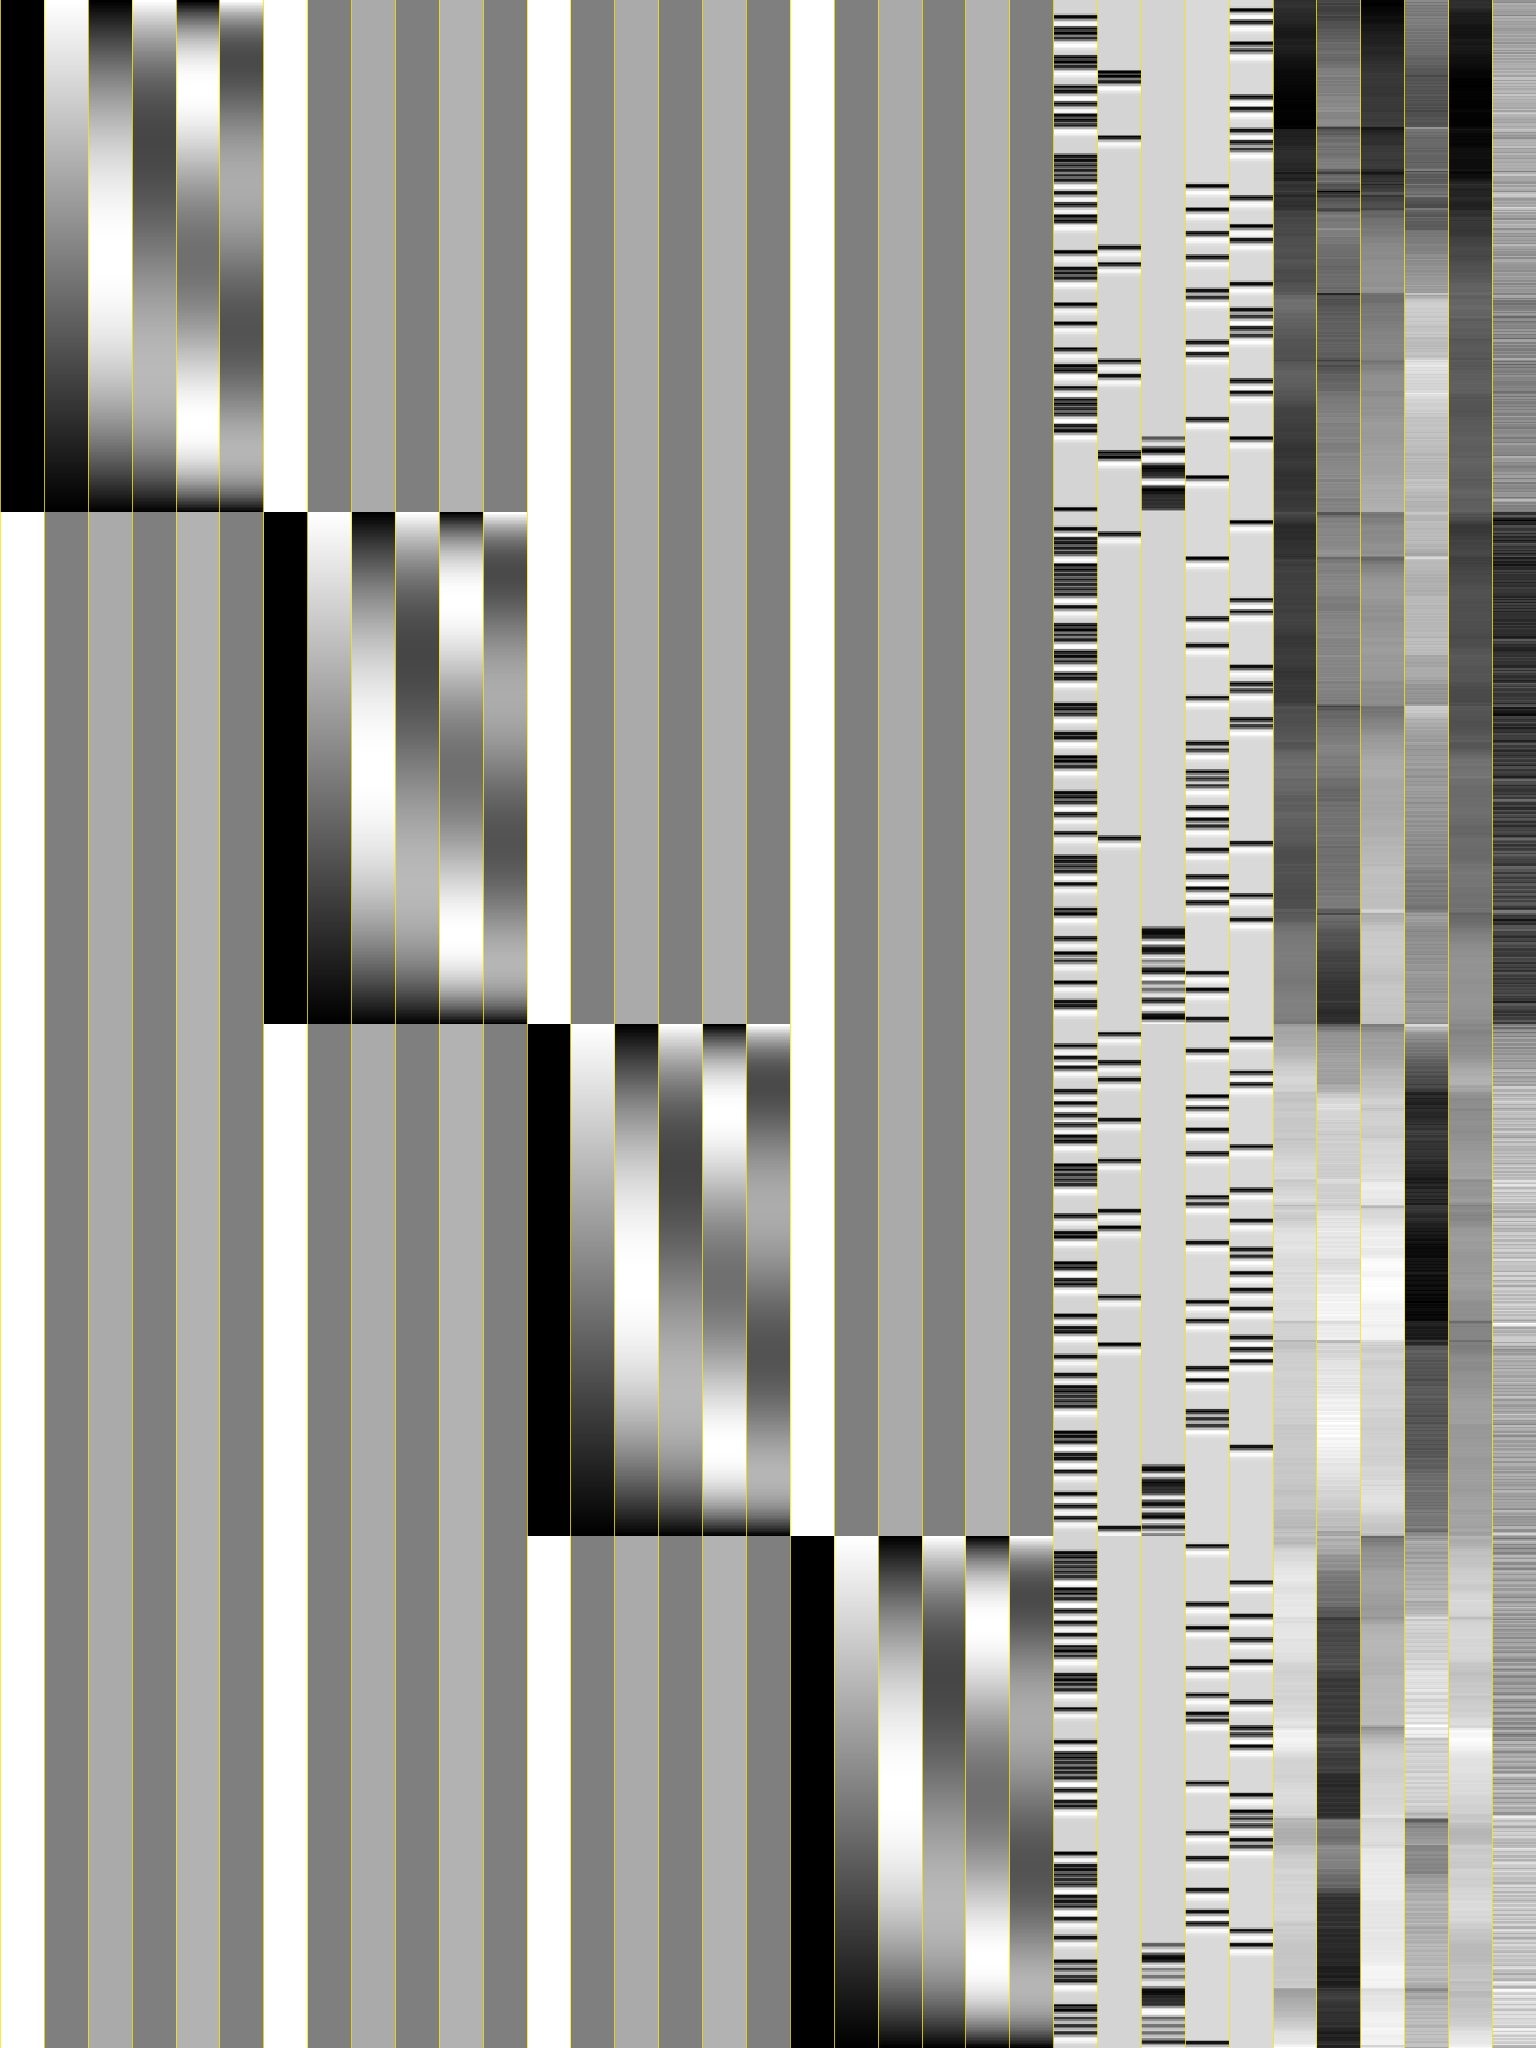

In [103]:
im_task = Image.open(os.path.join(evs_dir, 'X.task.jpg'))
im_task

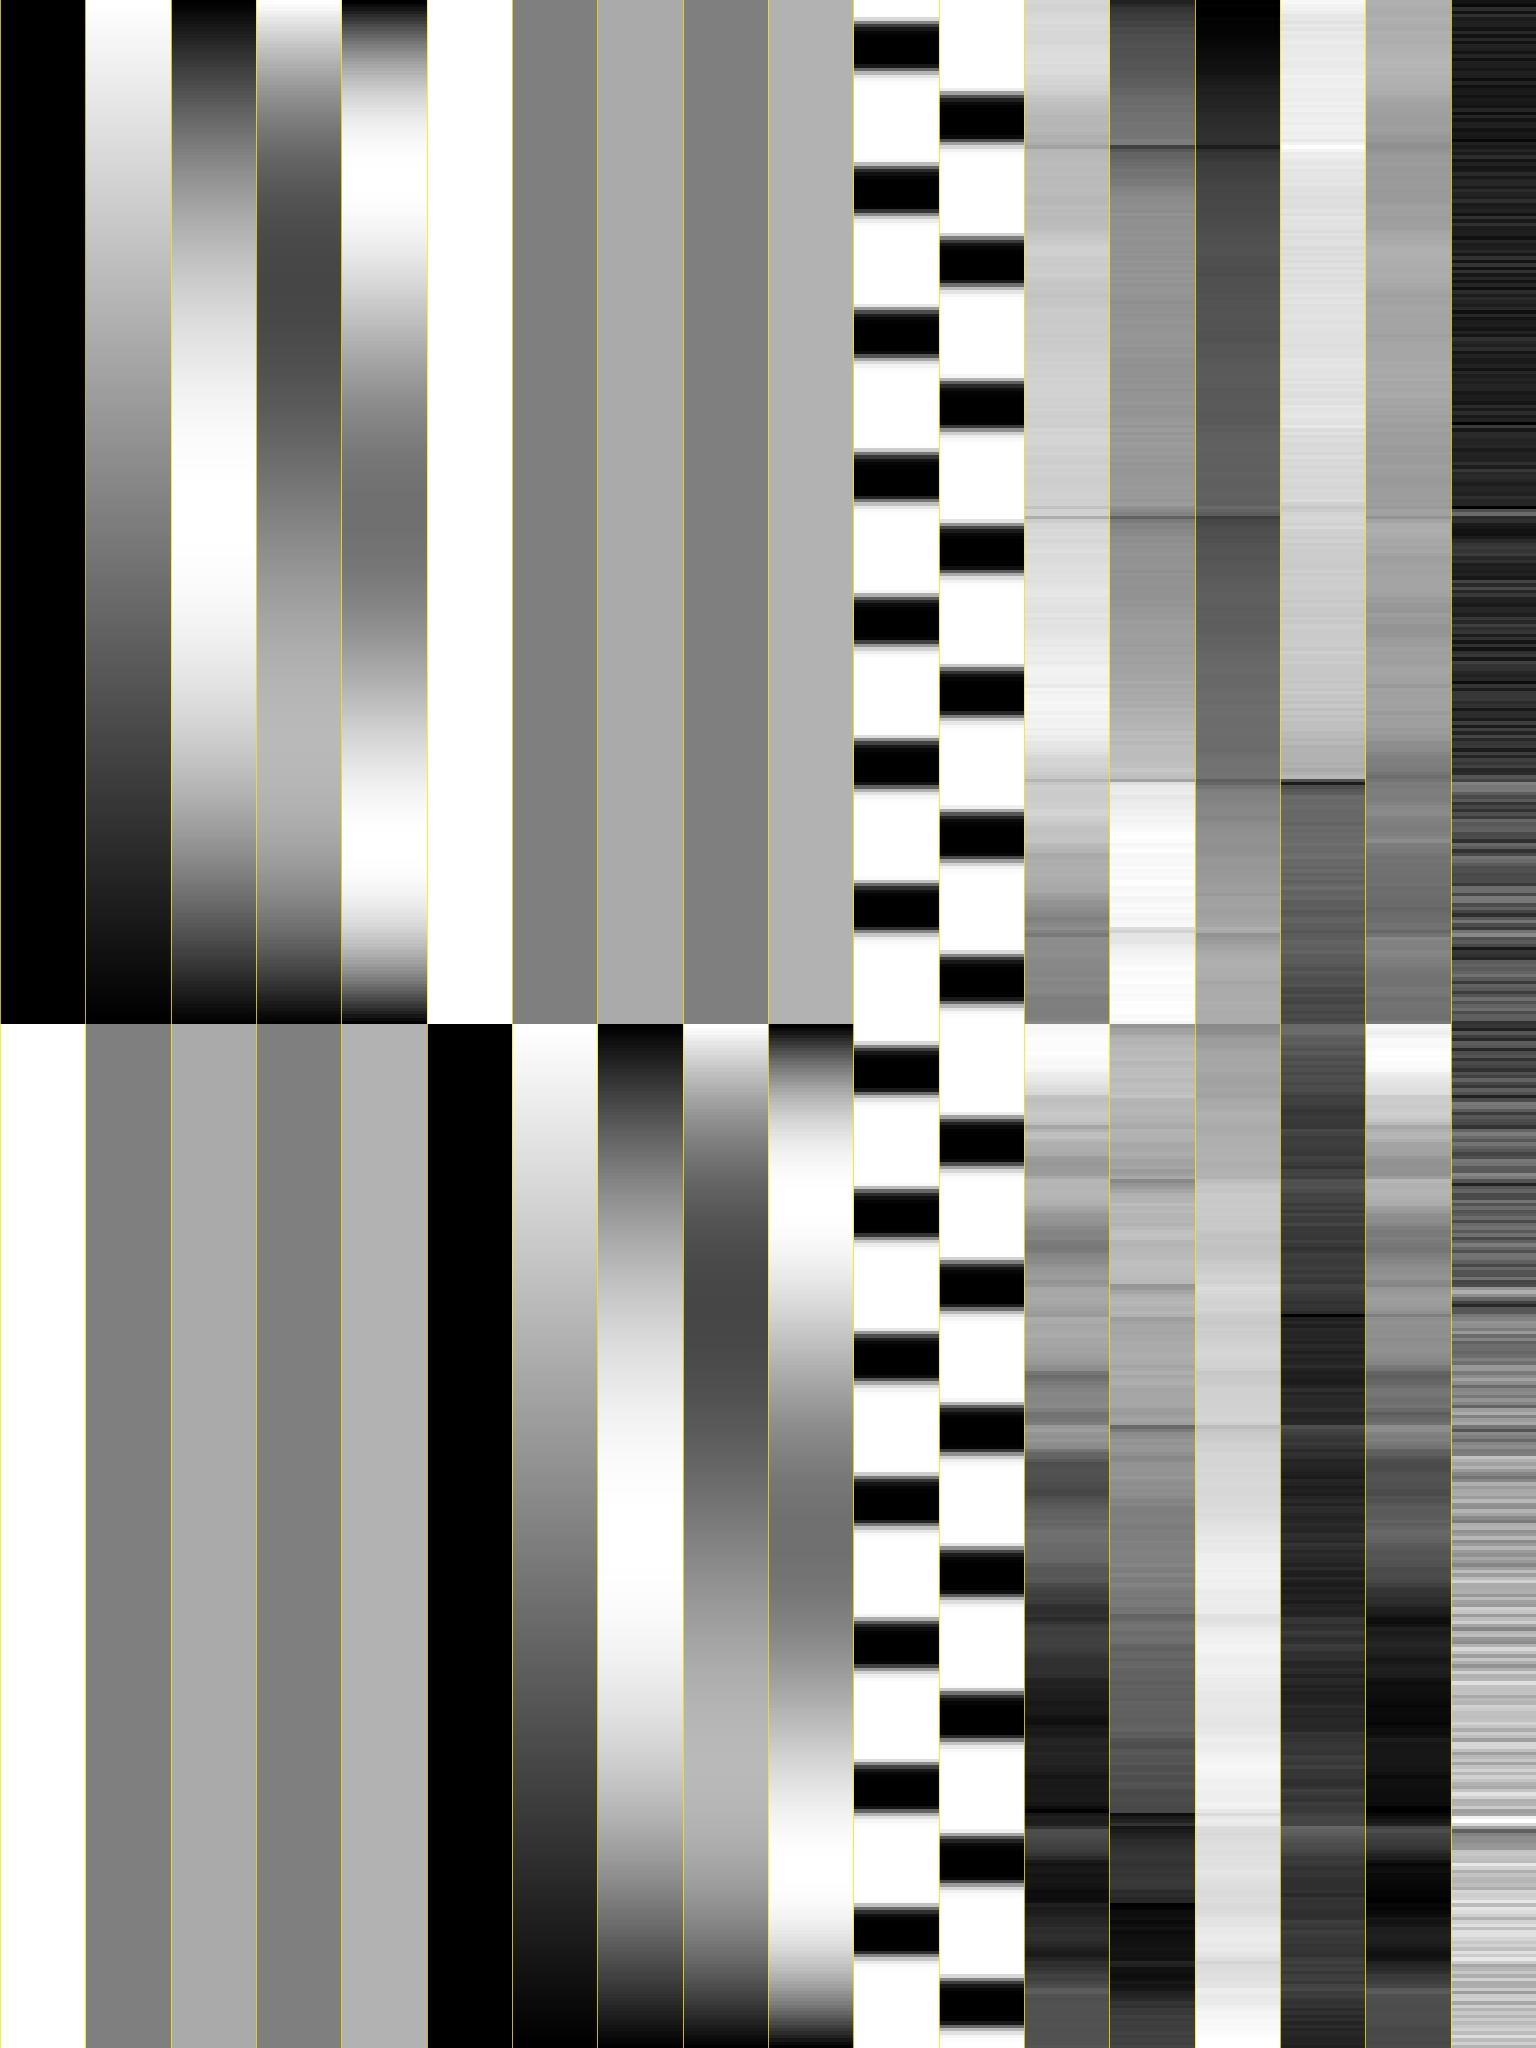

In [104]:
im_loc = Image.open(os.path.join(evs_dir, 'X.loc.jpg'))
im_loc